# Long Short Term Memory Network Model Implementation

This notebook implements two variants of a LSTM network to predict the next 24 hour ahead energy demand. Predictions are made at the end of each day for the maximum demand for each hour in the day ahead.

#### Data Structure
Two model variants are tested. A univariate case that uses only past energy demand to make the prediction. And a multivariate case that uses past energy demand, weather features (temperature, humidity, wind speed, rain, etc), and day of the week as predictors.

Data structure for the univarate case is described by the following diagram. In this case we are predicting hour-by-hour using previous data from the same hour. In this way each hour becomes a dataset on its own. We can combine these multiple sets into one single block of data with the shape:
- INPUT(samples, lags, hour slices)
- OUTPUT (samples, hour slices)

<img src="img/lstm-data-transform.png" width=800 height=400 align="middle">

Data structure for the multivariate case is described as follows. In this case we add features to the lags as a flattened 2D vector of the form (lags, features).
- INPUT (samples, lags & features, hourly slices)
- OUTPUT (samples, hourly slices)

<img src="img/lstm-data-input.png" width=600 height=400 align="middle">

#### Lagged Features
This workbook uses between 2 and 9 cross validations on small samples (1-3 years) in while maniuplating the number and composition of the lagged features. The default lags are the previous 7 days. First sequence of variants on this are the last 14, 30, 180, and 365 days. The second variant is to use the previous 7 days, and only multiples of 7 of the target day up to a maximum. I.e. A lag structure of a 30 day maxium lookback would be looksbacks of 1, 2, 3, 4, 5, 6, 7, 14, 21, 28. This was done because the autocorrelation between the target day and days at multiples of 7 is highest.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

import keras
import tensorflow
from keras.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from model_persistence import get_persistence_dataset, train_test_split, calculate_errors, plot_error
from features_preprocessing import make_shifted_features, transform_to_windows


Using TensorFlow backend.
/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ns/anaconda3/envs/bk_p

### Multiple Parallel output LSTM Model

Define a two stage lstm architecture with default 50 neurons and 25 neurons


In [17]:
###define an LSTM model
#takes in parallel inputs and outputs an equal number of parallel outputs
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

###### Setup and run crossvalidation of the model

- number of crossvalidations set to 10 over 1 year period.
- each sample is shaped (lags, hour_slices).
- number of lags is 7 day look back. i.e. using last 7 days to predict next 24 hours.

In [53]:
def run_lstm_pipe(n_lags=7, n_crossvals=5, show_verbose=False, epochs=20, extra_lag=False, long_lag_step=7, max_lookback=30, period_start = '2017-01-01', period_end = '2017-12-31'):

    n_hours = 24

    verbose = 0
    
    if show_verbose:
        verbose = 1

    #load the inital data
    working = get_persistence_dataset(start=period_start, stop=period_end)

    #transform into days and hours windows
    working_t = transform_to_windows(working)

    #normalize and return the inverse sacler
    working_norm, scaler = normalize_df(working_t)

    #split the sequences into X with lags, and Y the predicted value
    X, y = split_sequences(working_norm.values, n_lags, extra_lag=extra_lag, long_lag_step=long_lag_step, max_step=max_lookback, idx=0, multivar=False)
    
    n_features=X.shape[1]
    
    print('Crossvalidation run congifuration:')
    print('Number of lag features: {}' .format(n_features))
    print('Number of crossvalidations: {}' .format(n_crossvals))
    print('Date range from {} to {}'.format(period_start, period_end))
    
    print('X shape: {}'.format(X.shape))
    print('y shape: {}'.format(y.shape))
    
    #creates set sequences of the time series to cross validate on. 
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X, y):

        lstm_base = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)

        lstm_base.fit(X[train], y[train], epochs=epochs, verbose=verbose, shuffle=False)

        predict = lstm_base.predict(X[test], verbose=verbose)


        #inverse transform the predictions and actual values
        prediction = scaler.inverse_transform(predict)
        actual = scaler.inverse_transform(y[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)

    #convert results to numpy array for easy manipulation
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    #calculate and display the crossvalidated mean average errors 
    mae = get_sample_total_mae(actuals, predictions)

    #print a selection of the cross validated predictions. See how the sample predictions evolved.
    inspect_cv_predictions(actuals, predictions)
    
    return predictions, actuals

Crossvalidation run congifuration:
Number of lag features: 3
Number of crossvalidations: 9
Date range from 2017-01-01 to 2017-12-31
Sample 0 total MAE 1827.07, MAPE 6.51%
Sample 1 total MAE 2533.99, MAPE 9.77%
Sample 2 total MAE 1977.46, MAPE 7.24%
Sample 3 total MAE 2086.31, MAPE 6.87%
Sample 4 total MAE 2307.15, MAPE 7.90%
Sample 5 total MAE 1961.66, MAPE 7.14%
Sample 6 total MAE 1872.23, MAPE 6.79%
Sample 7 total MAE 1877.41, MAPE 6.71%
Sample 8 total MAE 2396.09, MAPE 8.56%
Mean crossvalidation MAE 2093.26 MAPE 7.50%


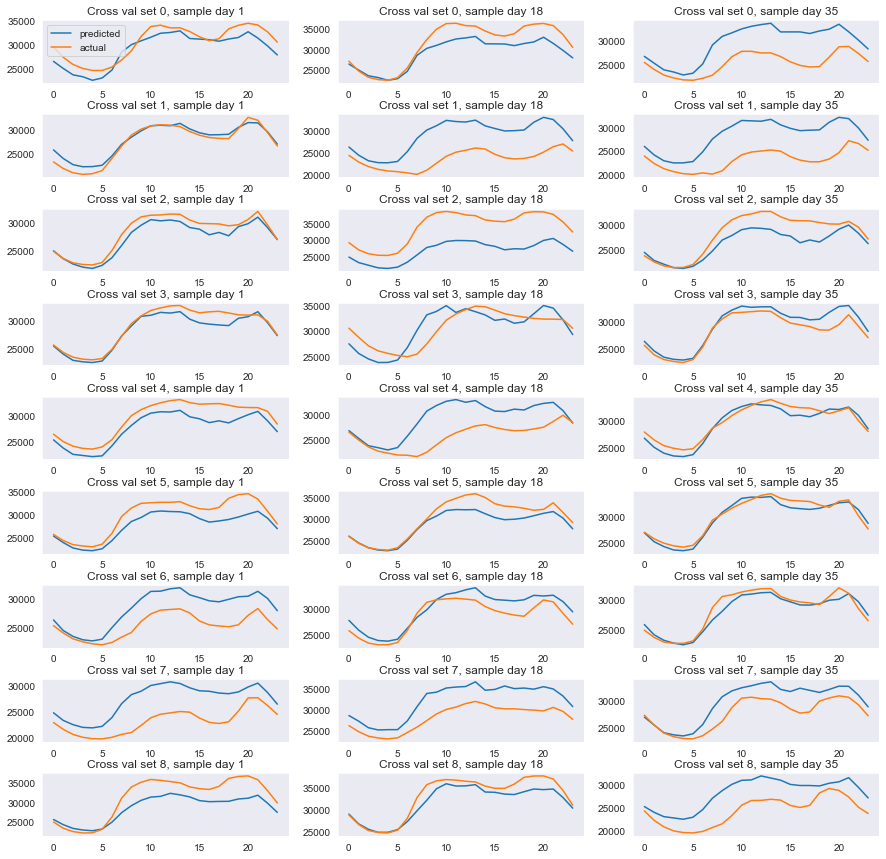

In [238]:
run_lstm_pipe(n_lags=3, n_crossvals=9, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 7
Number of crossvalidations: 9
Date range from 2017-01-01 to 2017-12-31
Sample 0 total MAE 1910.45, MAPE 7.07%
Sample 1 total MAE 2517.35, MAPE 9.88%
Sample 2 total MAE 2051.06, MAPE 7.45%
Sample 3 total MAE 2042.19, MAPE 7.00%
Sample 4 total MAE 2301.29, MAPE 8.09%
Sample 5 total MAE 1902.60, MAPE 6.84%
Sample 6 total MAE 1830.16, MAPE 6.81%
Sample 7 total MAE 1762.34, MAPE 6.29%
Sample 8 total MAE 2816.51, MAPE 9.68%
Mean crossvalidation MAE 2125.99 MAPE 7.68%


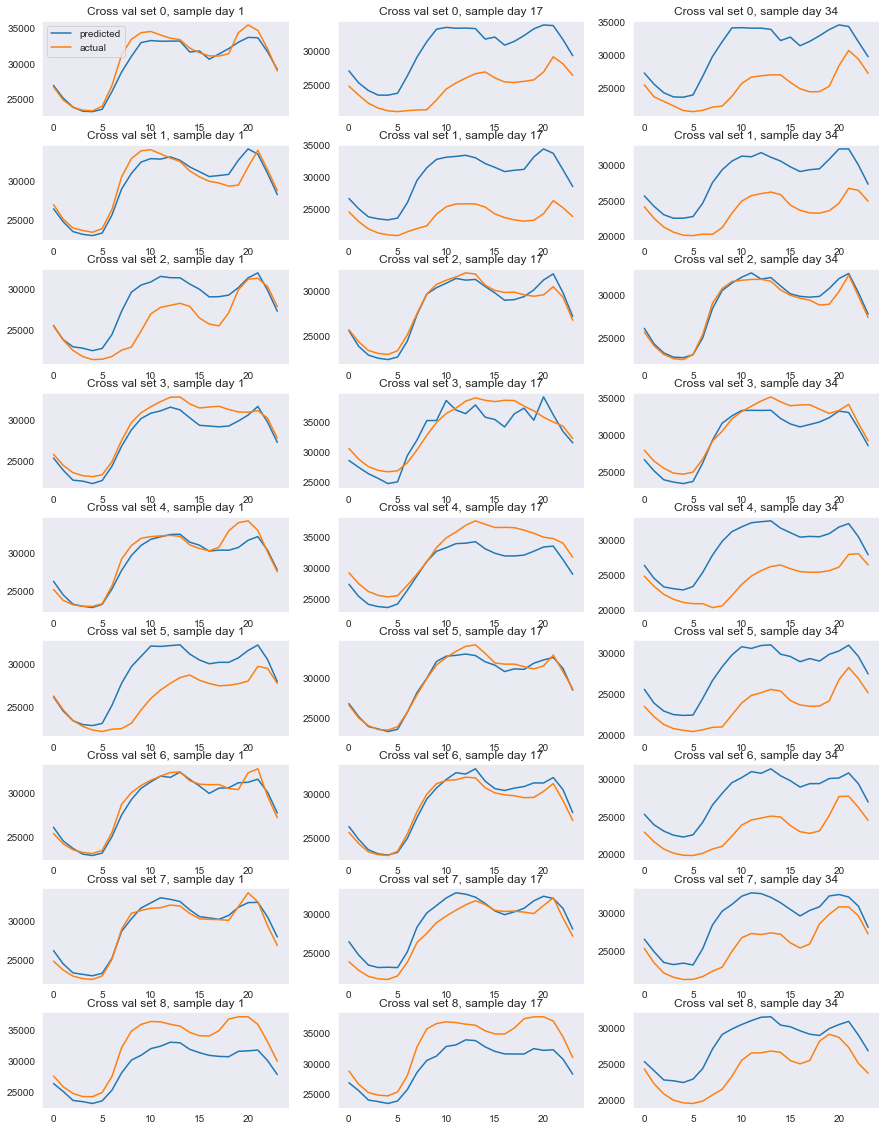

In [10]:
run_lstm_pipe(n_lags=7, n_crossvals=9, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 14
Number of crossvalidations: 9
Date range from 2017-01-01 to 2017-12-31
Sample 0 total MAE 1965.75, MAPE 7.32%
Sample 1 total MAE 2852.69, MAPE 11.27%
Sample 2 total MAE 2100.18, MAPE 7.78%
Sample 3 total MAE 2331.10, MAPE 7.92%
Sample 4 total MAE 2377.63, MAPE 8.35%
Sample 5 total MAE 1925.95, MAPE 7.07%
Sample 6 total MAE 1923.87, MAPE 7.18%
Sample 7 total MAE 1965.30, MAPE 6.98%
Sample 8 total MAE 2585.82, MAPE 8.98%
Mean crossvalidation MAE 2225.36 MAPE 8.09%


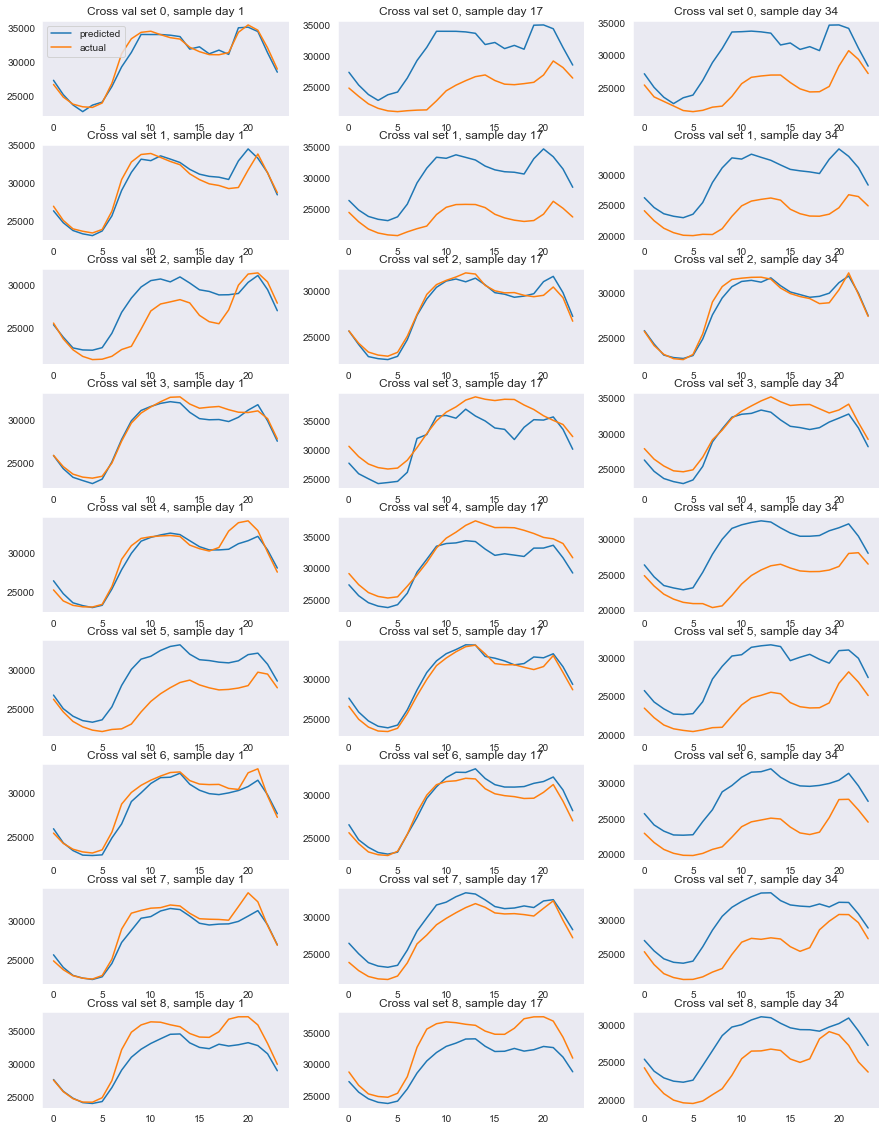

In [11]:
run_lstm_pipe(n_lags=14, n_crossvals=9, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 180
Number of crossvalidations: 2
Date range from 2015-01-01 to 2017-12-31
305/305 [==============================] - 5s 15ms/step
Sample 0 total MAE 17034.15, MAPE 58.69%
Sample 1 total MAE 2195.15, MAPE 8.02%
Mean crossvalidation MAE 9614.65 MAPE 33.36%


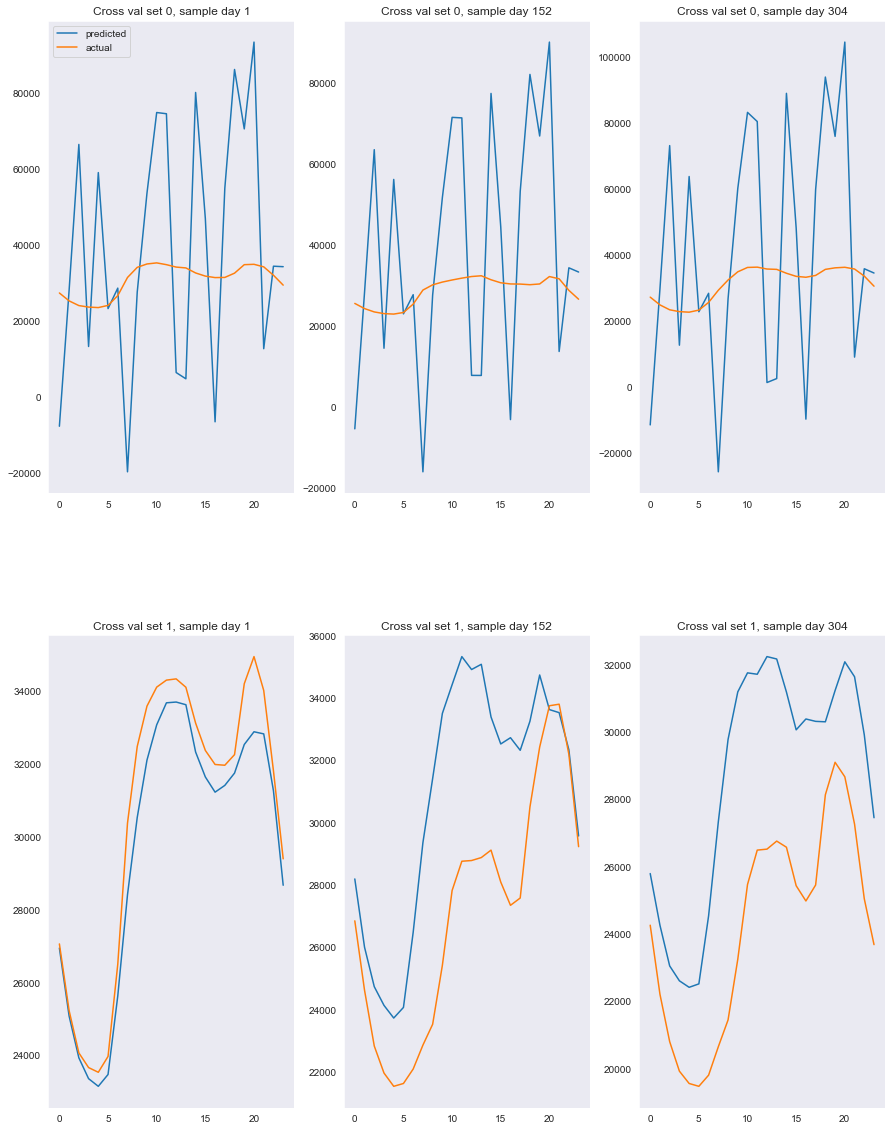

In [12]:
run_lstm_pipe(n_lags=180, n_crossvals=2, show_verbose=True, period_start = '2015-01-01', period_end = '2017-12-31')

In [21]:
run_lstm_pipe(n_lags=2, n_crossvals=2, show_verbose=True, period_start = '2015-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 2
Number of crossvalidations: 2
Date range from 2015-01-01 to 2017-12-31
X shape: (1094, 2, 24)
y shape: (1094, 24)


KeyboardInterrupt: 

Crossvalidation run congifuration:
Number of lag features: 7
Number of crossvalidations: 9
Date range from 2017-01-01 to 2017-12-31
X shape: (358, 7, 24)
y shape: (358, 24)
Epoch 1/50
43/43 [==============================] - 5s 107ms/step - loss: 0.5990
Epoch 2/50
43/43 [==============================] - 0s 2ms/step - loss: 0.4487
Epoch 3/50
43/43 [==============================] - 0s 2ms/step - loss: 0.3824
Epoch 4/50
43/43 [==============================] - 0s 1ms/step - loss: 0.3615
Epoch 5/50
43/43 [==============================] - 0s 1ms/step - loss: 0.3236
Epoch 6/50
43/43 [==============================] - 0s 1ms/step - loss: 0.2775
Epoch 7/50
43/43 [==============================] - 0s 2ms/step - loss: 0.2377
Epoch 8/50
43/43 [==============================] - 0s 2ms/step - loss: 0.2105
Epoch 9/50
43/43 [==============================] - 0s 2ms/step - loss: 0.1932
Epoch 10/50
43/43 [==============================] - 0s 2ms/step - loss: 0.1819
Epoch 11/50
43/43 [===============

148/148 [==============================] - 0s 982us/step - loss: 0.1273
Epoch 49/50
148/148 [==============================] - 0s 1ms/step - loss: 0.1248
Epoch 50/50
35/35 [==============================] - 2s 48ms/step
Epoch 1/50
183/183 [==============================] - 6s 33ms/step - loss: 0.4564
Epoch 2/50
183/183 [==============================] - 0s 968us/step - loss: 0.3280
Epoch 3/50
183/183 [==============================] - 0s 983us/step - loss: 0.2320
Epoch 4/50
183/183 [==============================] - 0s 1ms/step - loss: 0.1957
Epoch 5/50
183/183 [==============================] - 0s 1ms/step - loss: 0.1622
Epoch 6/50
183/183 [==============================] - 0s 1ms/step - loss: 0.1643
Epoch 7/50
183/183 [==============================] - 0s 1ms/step - loss: 0.1600
Epoch 8/50
183/183 [==============================] - 0s 1ms/step - loss: 0.1581
Epoch 9/50
183/183 [==============================] - 0s 1ms/step - loss: 0.1569
Epoch 10/50
183/183 [=========================

288/288 [==============================] - 1s 2ms/step - loss: 0.1209
Epoch 42/50
288/288 [==============================] - 0s 2ms/step - loss: 0.1226
Epoch 43/50
288/288 [==============================] - 0s 2ms/step - loss: 0.1246
Epoch 44/50
288/288 [==============================] - 0s 1ms/step - loss: 0.1297
Epoch 45/50
288/288 [==============================] - 0s 1ms/step - loss: 0.1324
Epoch 46/50
288/288 [==============================] - 0s 981us/step - loss: 0.1242
Epoch 47/50
288/288 [==============================] - 0s 955us/step - loss: 0.1275
Epoch 48/50
288/288 [==============================] - 0s 951us/step - loss: 0.1253
Epoch 49/50
288/288 [==============================] - 0s 933us/step - loss: 0.1178
Epoch 50/50
35/35 [==============================] - 2s 62ms/step
Epoch 1/50
323/323 [==============================] - 7s 22ms/step - loss: 0.3951
Epoch 2/50
323/323 [==============================] - 0s 1ms/step - loss: 0.2353
Epoch 3/50
323/323 [=================

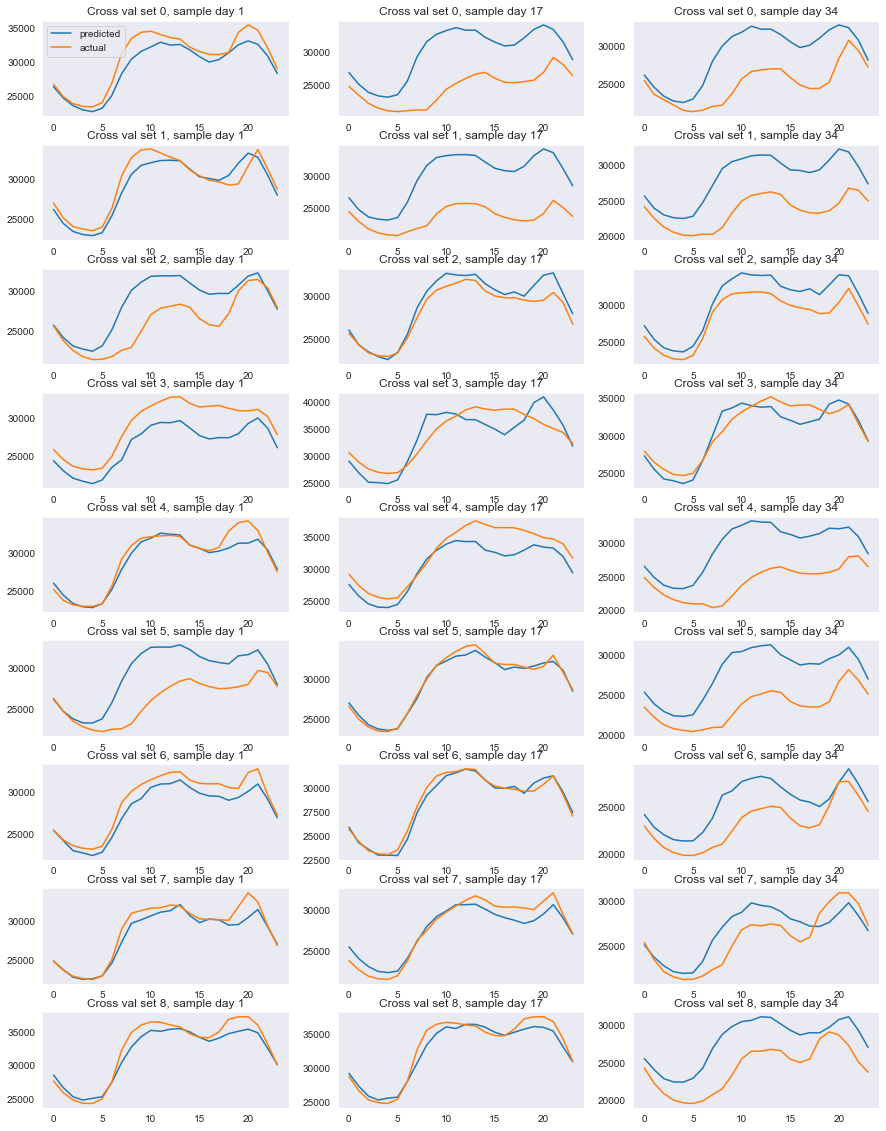

In [20]:
run_lstm_pipe(n_lags=7, n_crossvals=9, show_verbose=True, epochs=50, period_start = '2017-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 14
Number of crossvalidations: 3
Date range from 2017-01-01 to 2017-12-31
X shape: (305, 14, 24)
y shape: (305, 24)
Epoch 1/50
77/77 [==============================] - 8s 107ms/step - loss: 0.4288
Epoch 2/50
77/77 [==============================] - 0s 2ms/step - loss: 0.3390
Epoch 3/50
77/77 [==============================] - 0s 2ms/step - loss: 0.2793
Epoch 4/50
77/77 [==============================] - 0s 2ms/step - loss: 0.2394
Epoch 5/50
77/77 [==============================] - 0s 2ms/step - loss: 0.2096
Epoch 6/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1842
Epoch 7/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1670
Epoch 8/50
77/77 [==============================] - 0s 3ms/step - loss: 0.1642
Epoch 9/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1562
Epoch 10/50
77/77 [==============================] - 0s 2ms/step - loss: 0.1579
Epoch 11/50
77/77 [=============

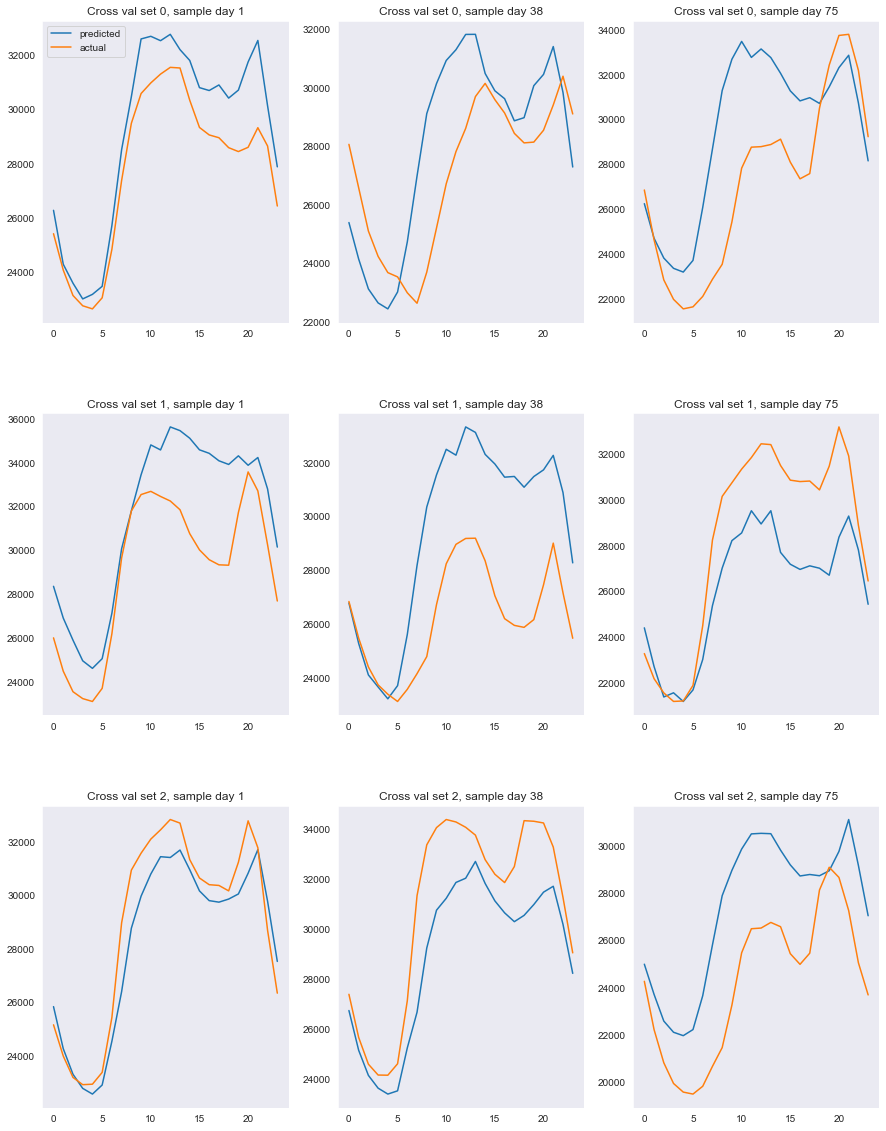

In [33]:
run_lstm_pipe(n_lags=7, 
              n_crossvals=3, 
              show_verbose=True, 
              epochs=50,
              extra_lag=True,
              long_lag_step=7, 
              max_lookback=60, 
              period_start = '2017-01-01', 
              period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 18
Number of crossvalidations: 3
Date range from 2017-01-01 to 2017-12-31
X shape: (275, 18, 24)
y shape: (275, 24)
Epoch 1/50
71/71 [==============================] - 9s 130ms/step - loss: 0.3796
Epoch 2/50
71/71 [==============================] - 0s 3ms/step - loss: 0.4477
Epoch 3/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2983
Epoch 4/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2650
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2832
Epoch 6/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2217
Epoch 7/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2030
Epoch 8/50
71/71 [==============================] - 0s 3ms/step - loss: 0.1845
Epoch 9/50
71/71 [==============================] - 0s 3ms/step - loss: 0.1820
Epoch 10/50
71/71 [==============================] - 0s 3ms/step - loss: 0.1669
Epoch 11/50
71/71 [=============

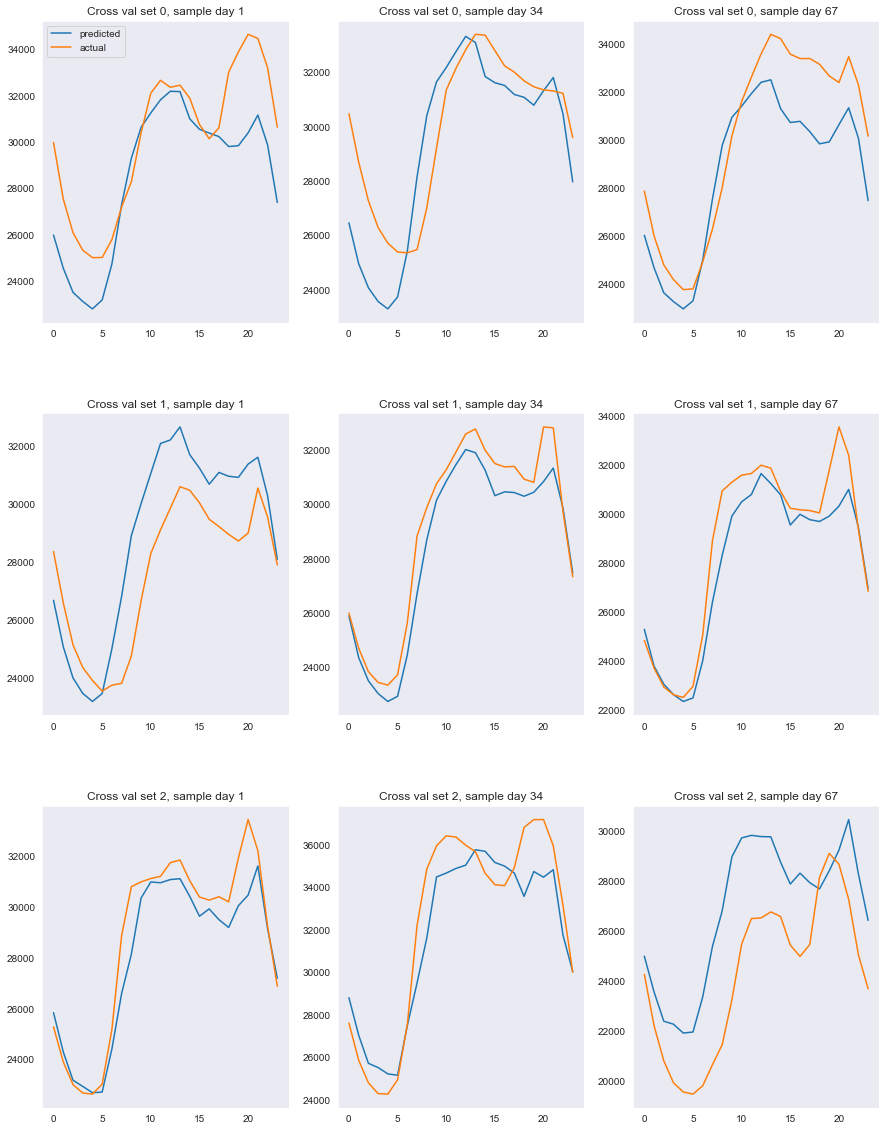

In [34]:
run_lstm_pipe(n_lags=7, 
              n_crossvals=3, 
              show_verbose=True, 
              epochs=50,
              extra_lag=True,
              long_lag_step=7, 
              max_lookback=90, 
              period_start = '2017-01-01', 
              period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 31
Number of crossvalidations: 3
Date range from 2016-01-01 to 2017-12-31
X shape: (551, 31, 24)
y shape: (551, 24)
Epoch 1/50
140/140 [==============================] - 11s 76ms/step - loss: 0.4266
Epoch 2/50
140/140 [==============================] - 1s 4ms/step - loss: 0.3282
Epoch 3/50
140/140 [==============================] - 1s 4ms/step - loss: 0.2960
Epoch 4/50
140/140 [==============================] - 1s 4ms/step - loss: 0.2175
Epoch 5/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1804
Epoch 6/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1522
Epoch 7/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1557
Epoch 8/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1466
Epoch 9/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1471
Epoch 10/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1443
Epoch 11/50


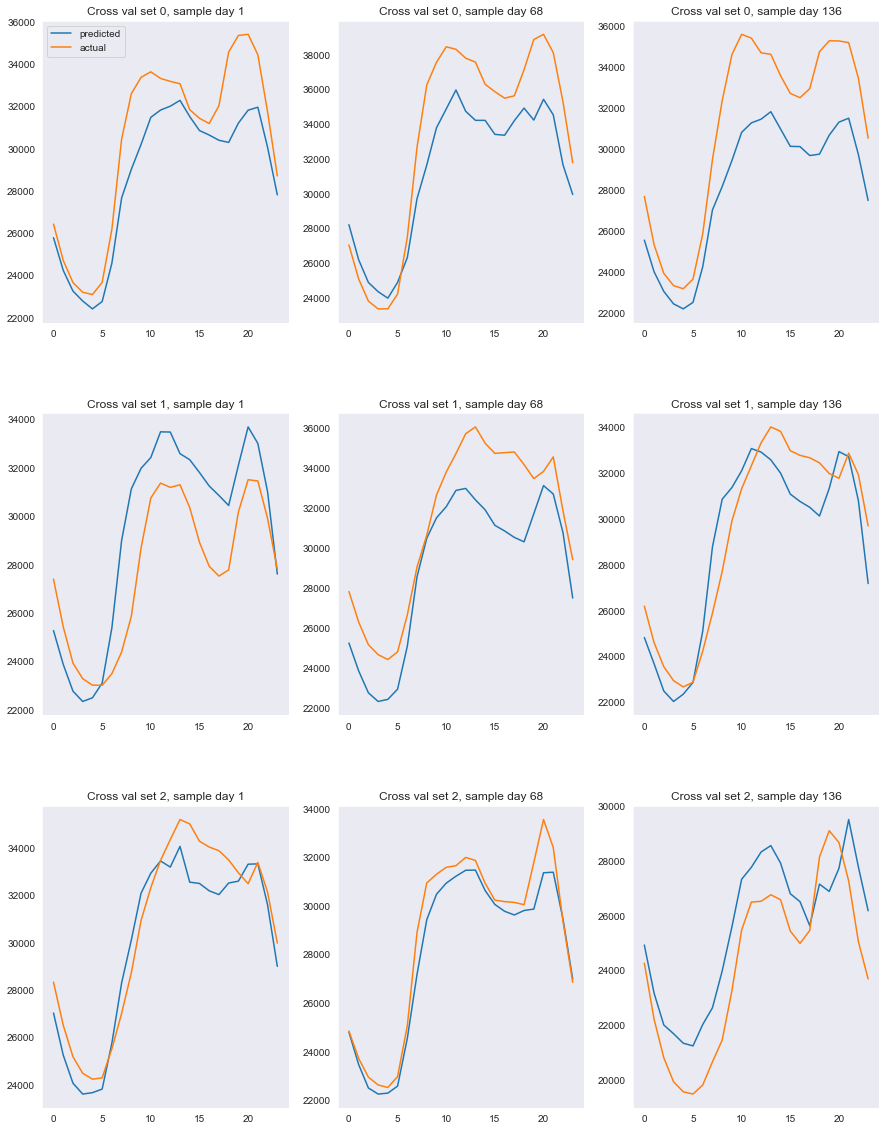

In [35]:
####################################################################################################
####################################################################################################
#Tests spanning 2 years!
####################################################################################################
####################################################################################################
run_lstm_pipe(n_lags=7, 
              n_crossvals=3, 
              show_verbose=True, 
              epochs=50,
              extra_lag=True,
              long_lag_step=7, 
              max_lookback=180, 
              period_start = '2016-01-01', 
              period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 31
Number of crossvalidations: 3
Date range from 2016-01-01 to 2017-12-31
X shape: (551, 31, 24)
y shape: (551, 24)
Epoch 1/100
140/140 [==============================] - 12s 83ms/step - loss: 0.4289
Epoch 2/100
140/140 [==============================] - 1s 4ms/step - loss: 0.2772
Epoch 3/100
140/140 [==============================] - 1s 4ms/step - loss: 0.2170
Epoch 4/100
140/140 [==============================] - 1s 4ms/step - loss: 0.2026
Epoch 5/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1670
Epoch 6/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1567
Epoch 7/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1456
Epoch 8/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1523
Epoch 9/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1472
Epoch 10/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1498
Ep

277/277 [==============================] - 1s 4ms/step - loss: 0.1203
Epoch 96/100
277/277 [==============================] - 1s 4ms/step - loss: 0.1181
Epoch 97/100
277/277 [==============================] - 1s 4ms/step - loss: 0.1168
Epoch 98/100
277/277 [==============================] - 1s 4ms/step - loss: 0.1149
Epoch 99/100
277/277 [==============================] - 1s 4ms/step - loss: 0.1158
Epoch 100/100
137/137 [==============================] - 4s 32ms/step
Epoch 1/100
414/414 [==============================] - 14s 33ms/step - loss: 0.3792
Epoch 2/100
414/414 [==============================] - 2s 4ms/step - loss: 0.2141
Epoch 3/100
414/414 [==============================] - 2s 4ms/step - loss: 0.1615
Epoch 4/100
414/414 [==============================] - 2s 4ms/step - loss: 0.1493
Epoch 5/100
414/414 [==============================] - 2s 4ms/step - loss: 0.1463
Epoch 6/100
414/414 [==============================] - 2s 4ms/step - loss: 0.1445
Epoch 7/100
414/414 [=============

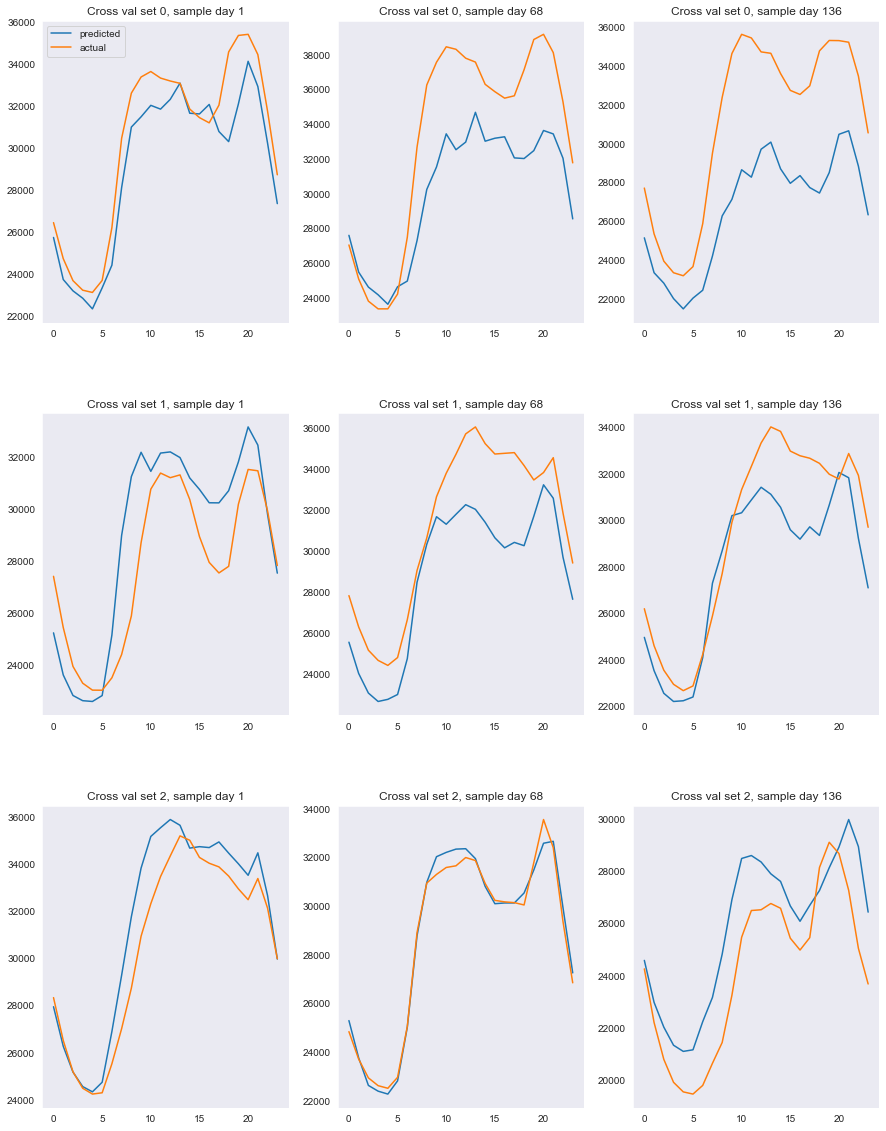

In [36]:
run_lstm_pipe(n_lags=7, 
              n_crossvals=3, 
              show_verbose=True, 
              epochs=100,
              extra_lag=True,
              long_lag_step=7, 
              max_lookback=180, 
              period_start = '2016-01-01', 
              period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 58
Number of crossvalidations: 3
Date range from 2015-01-01 to 2017-12-31
X shape: (731, 58, 24)
y shape: (731, 24)
Epoch 1/100
185/185 [==============================] - 13s 70ms/step - loss: 0.3737
Epoch 2/100
185/185 [==============================] - 1s 7ms/step - loss: 0.2733
Epoch 3/100
185/185 [==============================] - 1s 7ms/step - loss: 0.2184
Epoch 4/100
185/185 [==============================] - 1s 7ms/step - loss: 0.1801
Epoch 5/100
185/185 [==============================] - 1s 7ms/step - loss: 0.1540
Epoch 6/100
185/185 [==============================] - 1s 7ms/step - loss: 0.1503
Epoch 7/100
185/185 [==============================] - 1s 7ms/step - loss: 0.1451
Epoch 8/100
185/185 [==============================] - 1s 7ms/step - loss: 0.1477
Epoch 9/100
185/185 [==============================] - 1s 7ms/step - loss: 0.1466
Epoch 10/100
185/185 [==============================] - 1s 7ms/step - loss: 0.1515
Ep

367/367 [==============================] - 2s 7ms/step - loss: 0.1018
Epoch 96/100
367/367 [==============================] - 2s 7ms/step - loss: 0.1004
Epoch 97/100
367/367 [==============================] - 3s 7ms/step - loss: 0.1005
Epoch 98/100
367/367 [==============================] - 3s 7ms/step - loss: 0.0971
Epoch 99/100
367/367 [==============================] - 2s 7ms/step - loss: 0.1021
Epoch 100/100
182/182 [==============================] - 5s 27ms/step
Epoch 1/100
549/549 [==============================] - 16s 29ms/step - loss: 0.6250
Epoch 2/100
549/549 [==============================] - 4s 7ms/step - loss: 0.1939
Epoch 3/100
549/549 [==============================] - 4s 7ms/step - loss: 0.1504
Epoch 4/100
549/549 [==============================] - 4s 7ms/step - loss: 0.1420
Epoch 5/100
549/549 [==============================] - 4s 7ms/step - loss: 0.1408
Epoch 6/100
549/549 [==============================] - 4s 7ms/step - loss: 0.1410
Epoch 7/100
549/549 [=============

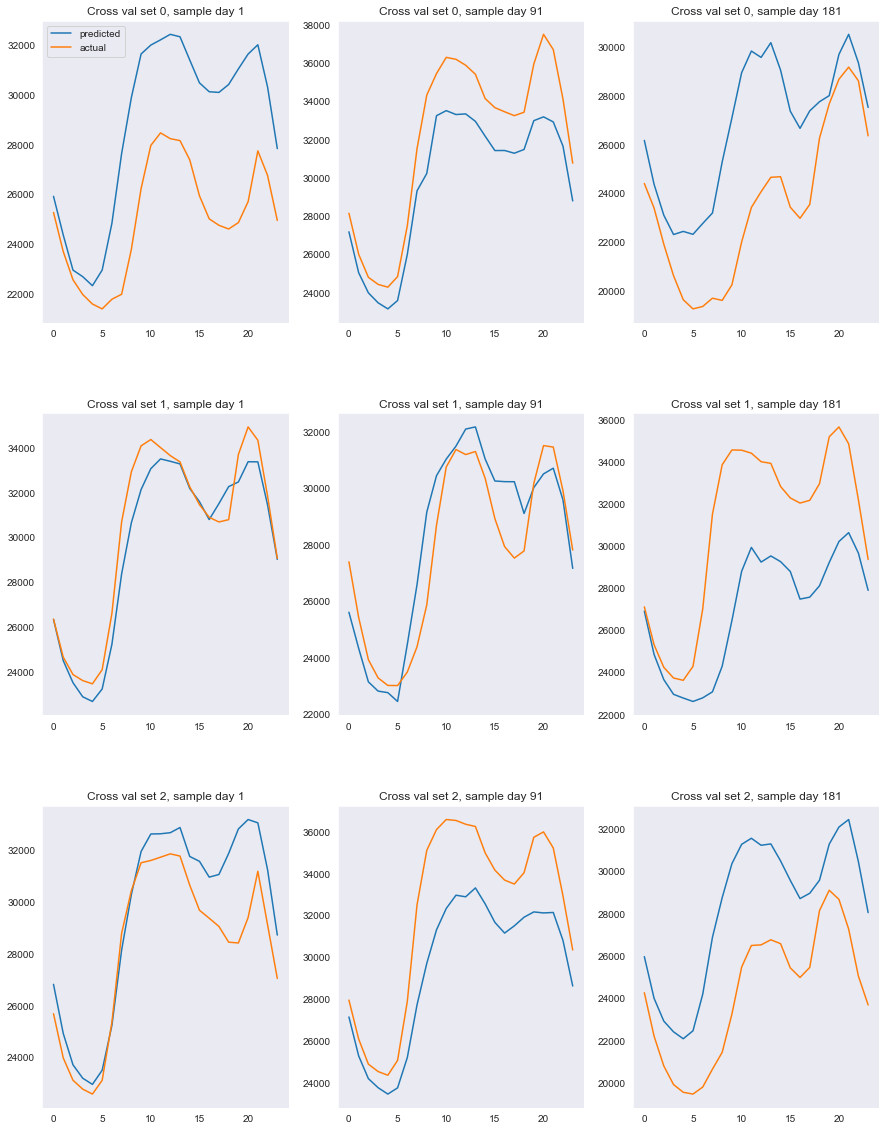

In [37]:
####################################################################################################
####################################################################################################
#Tests spanning 3 years!
####################################################################################################
####################################################################################################
run_lstm_pipe(n_lags=7, 
              n_crossvals=3, 
              show_verbose=True, 
              epochs=100,
              extra_lag=True,
              long_lag_step=7, 
              max_lookback=365, 
              period_start = '2015-01-01', 
              period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 31
Number of crossvalidations: 3
Date range from 2016-01-01 to 2017-12-31
X shape: (551, 31, 24)
y shape: (551, 24)
Epoch 1/100
140/140 [==============================] - 20s 146ms/step - loss: 0.5066
Epoch 2/100
140/140 [==============================] - 1s 4ms/step - loss: 0.4140
Epoch 3/100
140/140 [==============================] - 1s 4ms/step - loss: 0.3294
Epoch 4/100
140/140 [==============================] - 1s 4ms/step - loss: 0.2380
Epoch 5/100
140/140 [==============================] - 1s 4ms/step - loss: 0.2012
Epoch 6/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1603
Epoch 7/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1580
Epoch 8/100
140/140 [==============================] - 1s 5ms/step - loss: 0.1437
Epoch 9/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1548
Epoch 10/100
140/140 [==============================] - 1s 4ms/step - loss: 0.1525
E

277/277 [==============================] - 1s 4ms/step - loss: 0.1065
Epoch 96/100
277/277 [==============================] - 1s 4ms/step - loss: 0.1052
Epoch 97/100
277/277 [==============================] - 1s 4ms/step - loss: 0.1042
Epoch 98/100
277/277 [==============================] - 1s 4ms/step - loss: 0.1038
Epoch 99/100
277/277 [==============================] - 1s 4ms/step - loss: 0.1039
Epoch 100/100
137/137 [==============================] - 6s 44ms/step
Epoch 1/100
414/414 [==============================] - 17s 42ms/step - loss: 0.4676
Epoch 2/100
414/414 [==============================] - 2s 4ms/step - loss: 0.2683
Epoch 3/100
414/414 [==============================] - 2s 4ms/step - loss: 0.1765
Epoch 4/100
414/414 [==============================] - 2s 4ms/step - loss: 0.1446
Epoch 5/100
414/414 [==============================] - 2s 4ms/step - loss: 0.1446
Epoch 6/100
414/414 [==============================] - 2s 4ms/step - loss: 0.1446
Epoch 7/100
414/414 [=============

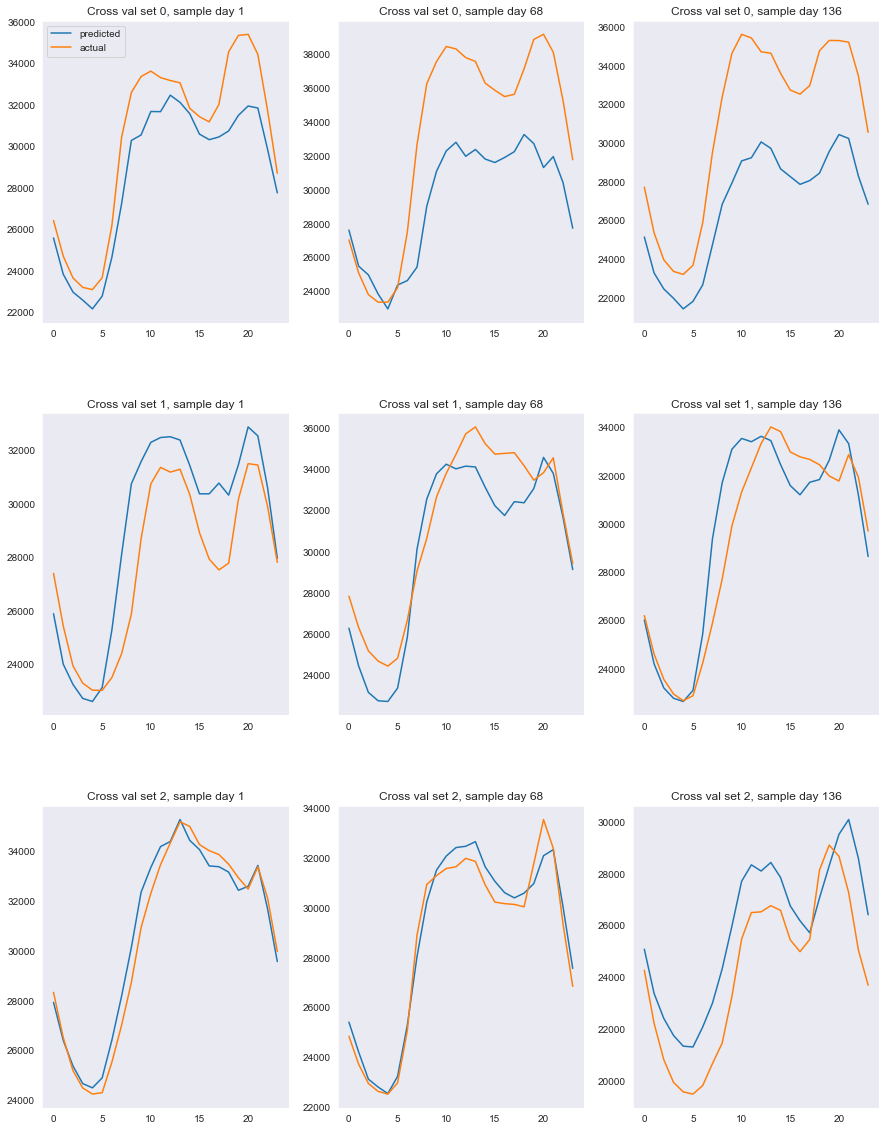

In [54]:
predictions, actuals = run_lstm_pipe(n_lags=7, 
                                     n_crossvals=3, 
                                     show_verbose=True,
                                     epochs=100,
                                     extra_lag=True,
                                     long_lag_step=7, 
                                     max_lookback=180, 
                                     period_start = '2016-01-01', 
                                     period_end = '2017-12-31')

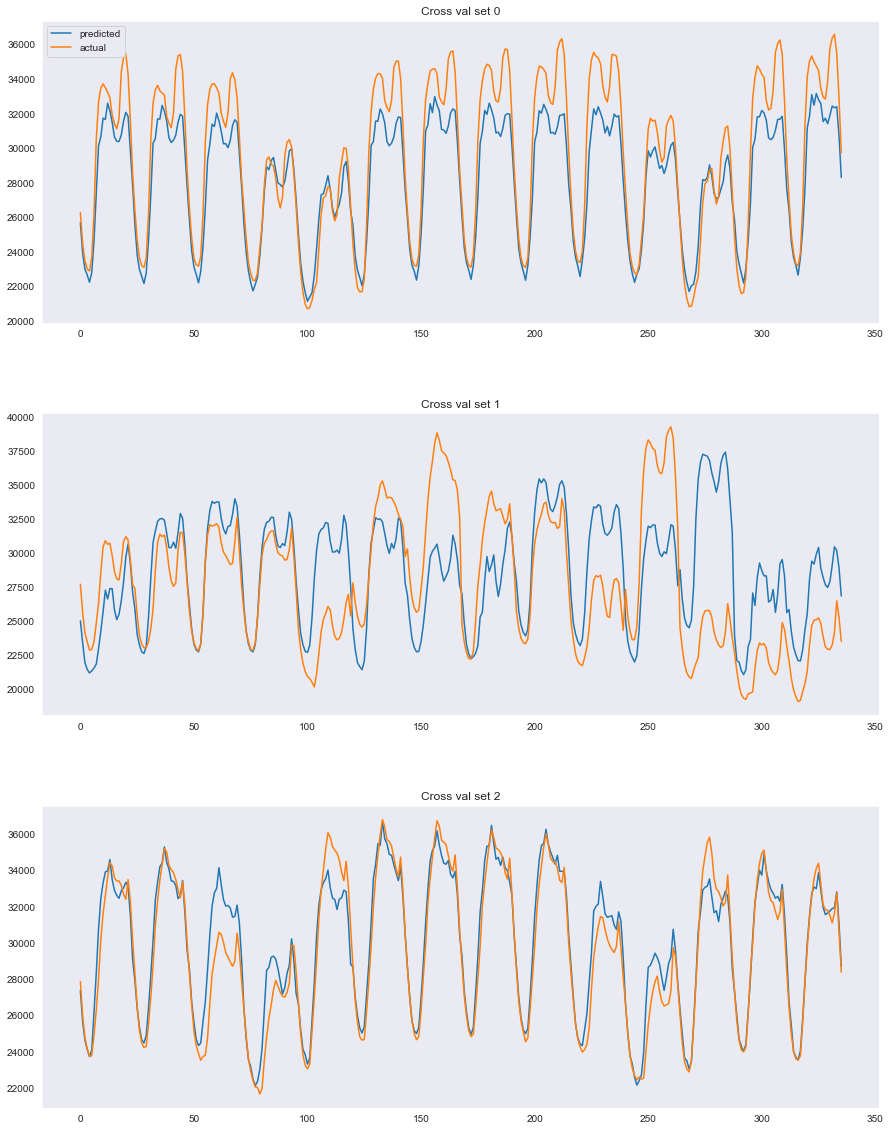

In [87]:
cv_week_predictions(actuals, predictions, num_days=14)

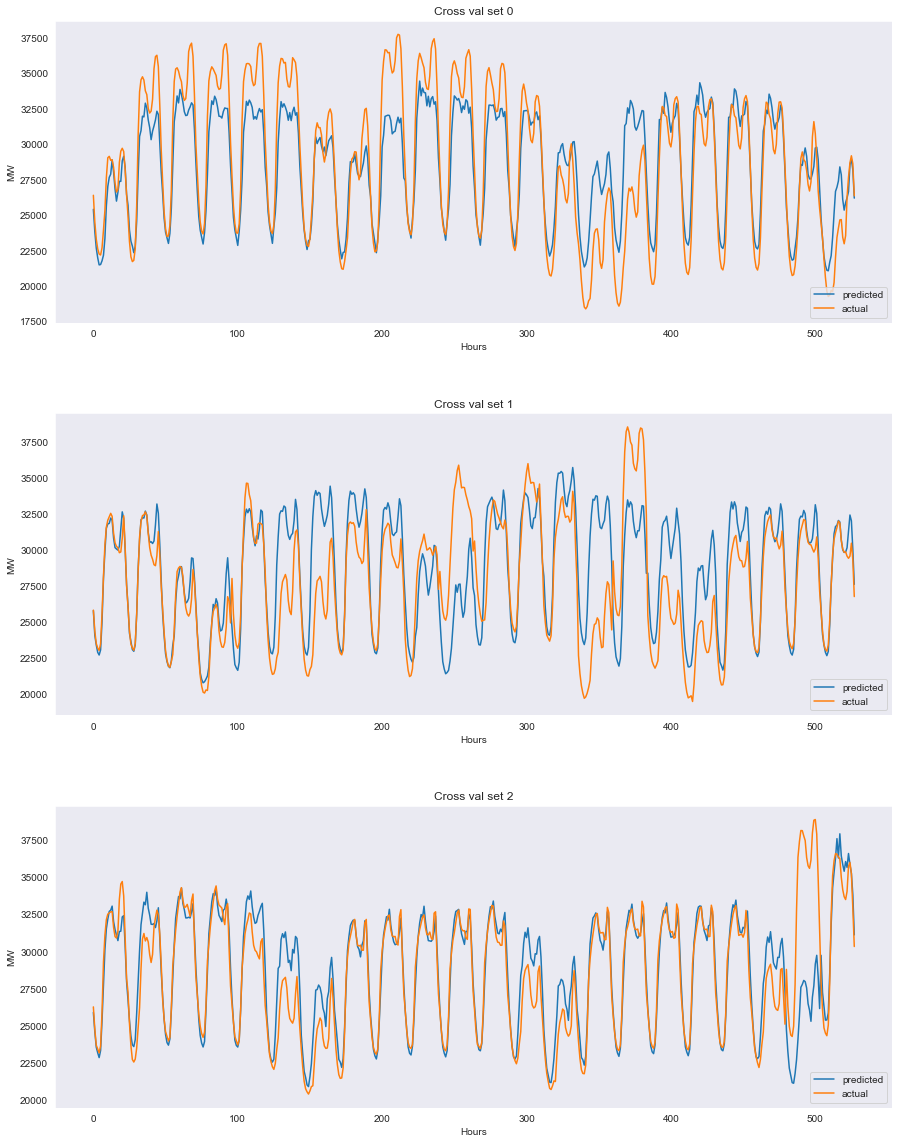

In [110]:
cv_week_predictions(actuals, predictions, num_days=3*7+1, shift=25)

### HELPER FUNCTIONS
###### Define a function to calculate and capture the mae

This could be done in keras directly with the model.evaluate feature. However that will return the scaled values. We are interested in comparing our results with other models and therefore choose to use the model.predict.

In [2]:
def normalize_df(data):
    
    #normalize the dataset for working with the lstm nn
    scaler = MinMaxScaler().fit(data.values)
    data_normd = scaler.transform(data.values)

    data = pd.DataFrame(data_normd, index=data.index, columns=data.columns)
    
    return data, scaler

In [3]:
def sample_mape(actual, predicted):
    
    #calcualtes the mean absolute percent error per cross validated sample
    #returns as a percentage
    
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [4]:
#define a function to calcualte and capture the mae

def get_sample_total_mae(actual, predicted):
    #list to save scores
    maes = []
    mapes = []

    #loop through each crossvalidation sample
    for i in range(actual.shape[0]):
        
        #calcualte the mae and save to list
        mae = mean_absolute_error(actual[i], predicted[i])
        mape = sample_mape(actual[i], predicted[i])
        
        maes.append(mae)
        mapes.append(mape)
        print('Sample {} total MAE {:.2f}, MAPE {:.2f}%'.format(i,mae, mape))
        
    maes_total = np.mean(maes)
    mape_total = np.mean(mapes)
    
    print('Mean crossvalidation MAE {:.2f} MAPE {:.2f}%'. format(maes_total, mape_total))
        
    return maes, mapes

In [5]:
def inspect_cv_predictions(actuals, predictions):

    #the number of cross validation sets
    plots = predictions.shape[0]
    
    #the first day, middle day, and last days of the validation set
    days = [1, int(predictions.shape[1]/2), predictions.shape[1]-1]
    
    #set figure
    fig, axs = plt.subplots(plots,3, figsize=(15,20))

    #loop through the samples then loop through the days
    for i, axe in zip(range(plots), axs):
        for day, ax in zip(days, axe):
            
            #plot the predictions
            ax.plot(predictions[i][day], label='predicted')
            #plot actual values
            ax.plot(actuals[i][day], label='actual')
            ax.set_title('Cross val set {}, sample day {}'.format(i,day))

    #position the legend in the top left position of the top left chart.
    axs[0][0].legend(loc=2)
    plt.subplots_adjust(hspace=0.3)

In [100]:
def cv_week_predictions(actuals, predictions, num_days=7, shift=0):

    #the number of cross validation sets
    plots = predictions.shape[0]
    
    #the first day, middle day, and last days of the validation set
    
    days = [x+shift for x in range(num_days)]
    #days = [1, int(predictions.shape[1]/2), predictions.shape[1]-1]
    
    #set figure
    fig, axs = plt.subplots(plots,1, figsize=(15,20))

    #loop through the samples then loop through the days
    for i, ax in zip(range(plots), axs):
        #for day, ax in zip(days, axe):
            
        #plot the predictions
        ax.plot(predictions[i][days].flatten(), label='predicted')
        #plot actual values
        ax.plot(actuals[i][days].flatten(), label='actual')
        ax.set_title('Cross val set {}'.format(i))
        ax.set_xlabel('Hours')
        ax.set_ylabel('MW')

        #position the legend in the top left position of the top left chart.
        axs[i].legend(loc='lower right')
    plt.subplots_adjust(hspace=0.3)

In [44]:
def split_sequences(sequences, n_steps, extra_lag=False, long_lag_step=7, max_step=30, idx=0, multivar=False):
    """
    Function modified for use from Deep learning time series forecasting by Jason Brownlee
    """
    
    #if not adding extra lag features adjust max_step and n_steps to aling
    if not extra_lag:
        max_step=n_steps
        n_steps+=1
        
    
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        #end_ix = i + n_steps
        end_ix = i + max_step
        
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -long_lag_step)]
        
        #reverse the slice indexes
        slices = list(reversed(slices))
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break


        # gather input and output parts of the pattern
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:,idx]
    
    return X, y

# Multivariable - Multiple Parallel Output LSTM

In [7]:
###define an LSTM model
#takes in parallel inputs and outputs an equal number of parallel outputs
def lstm_multi_in_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

In [47]:
def run_multi_var_lstm_pipe(n_lags=2, n_crossvals=2, epochs=5, lr = 1e-3, extra_lag=False, long_lag_step=7, max_lookback=30, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31'):

    
    n_hours = 24


    #load the inital data
    X_multi, y_multi, scaler_multi = get_lstm_multivariable_data_3d(start=period_start, 
                                                                    stop=period_end, 
                                                                    n_lags=n_lags, 
                                                                    extra_lag=extra_lag, 
                                                                    long_lag_step=long_lag_step, 
                                                                    max_lookback=max_lookback)


    n_features = X_multi.shape[1]


    if show_verbose:
        verbose = 1
    else:
        verbose = 0


    print('Crossvalidation run congifuration:')
    print('Number of crossvalidations: {}' .format(n_crossvals))
    print('Number of total feature vectors: {}' .format(n_features))
    #print('Date range from {} to {}'.format(period_start, period_end))


    print(X_multi.shape)
    print(y_multi.shape)


    #creates set sequences of the time series to cross validate on. 
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    # #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X_multi, y_multi):

        lstm_multi = lstm_multi_in_parallel_out(n_features, n_hours, learning_rate=lr)


        lstm_multi.fit(X_multi[train], y_multi[train], epochs=epochs, verbose=verbose, shuffle=False)

        predict = lstm_multi.predict(X_multi[test], verbose=verbose)


        #inverse transform the predictions and actual values
        prediction = scaler_multi.inverse_transform(predict)
        actual = scaler_multi.inverse_transform(y_multi[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)


    #convert results to numpy array for easy manipulation
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    print(predictions.shape)
    print(actuals.shape)
    #calculate and display the crossvalidated mean average errors 
    mae = get_sample_total_mae(actuals, predictions)

    #print a selection of the cross validated predictions. See how the sample predictions evolved.
    inspect_cv_predictions(actuals, predictions)

Crossvalidation run congifuration:
Number of lag features: 2
Number of crossvalidations: 2
Number of total feature vectors: 20
(363, 20, 24)
(363, 24)
Epoch 1/50
121/121 [==============================] - 3s 25ms/step - loss: 0.3919
Epoch 2/50
121/121 [==============================] - 0s 3ms/step - loss: 0.2962
Epoch 3/50
121/121 [==============================] - 0s 3ms/step - loss: 0.1767
Epoch 4/50
121/121 [==============================] - 0s 3ms/step - loss: 0.1462
Epoch 5/50
121/121 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 6/50
121/121 [==============================] - 0s 3ms/step - loss: 0.1394
Epoch 7/50
121/121 [==============================] - 0s 3ms/step - loss: 0.1198
Epoch 8/50
121/121 [==============================] - 0s 3ms/step - loss: 0.1214
Epoch 9/50
121/121 [==============================] - 0s 3ms/step - loss: 0.1251
Epoch 10/50
121/121 [==============================] - 0s 3ms/step - loss: 0.1179
Epoch 11/50
121/121 [================

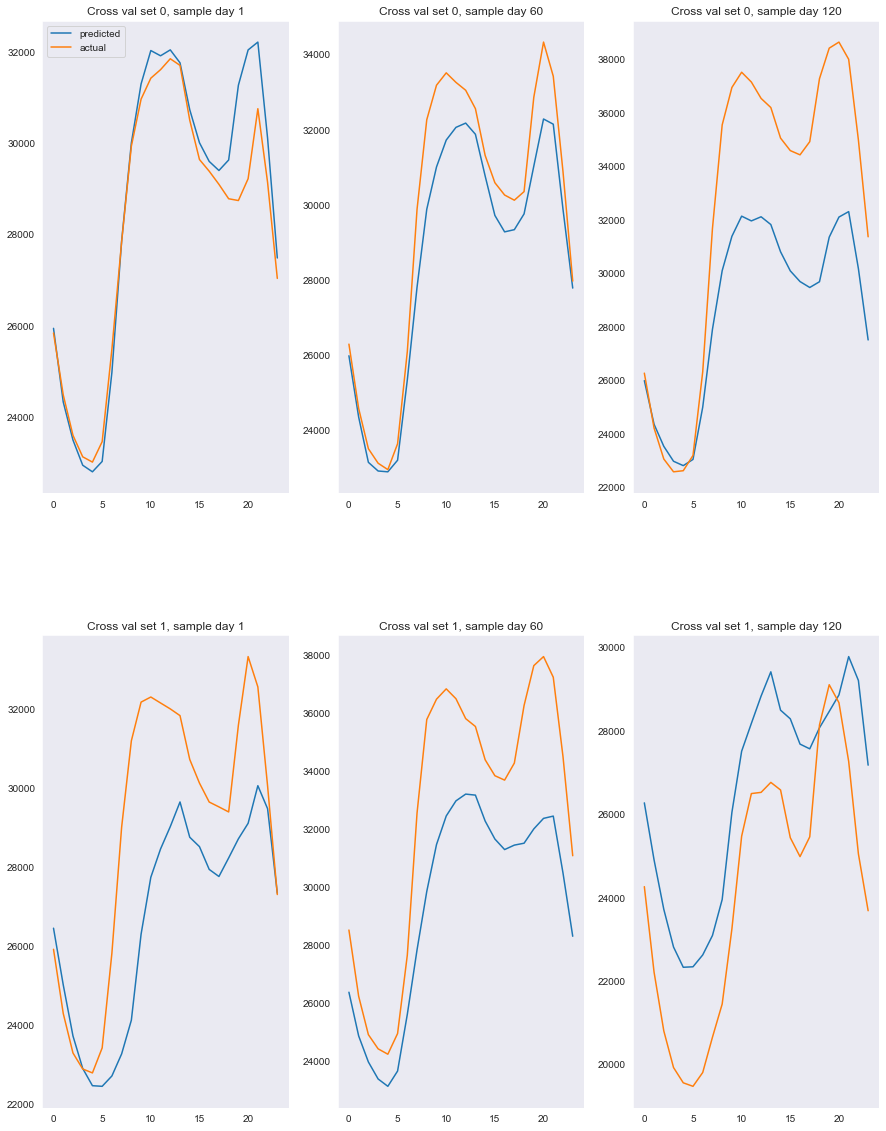

In [12]:
run_multi_var_lstm_pipe(n_lags=2, 
                        n_crossvals=2, 
                        epochs=50, 
                        lr = 1e-2, 
                        show_verbose=True, 
                        period_start = '2017-01-01', 
                        period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 7
Number of crossvalidations: 2
Number of total feature vectors: 70
(358, 70, 24)
(358, 24)
Epoch 1/50
120/120 [==============================] - 4s 37ms/step - loss: 0.4450
Epoch 2/50
120/120 [==============================] - 1s 8ms/step - loss: 0.4290
Epoch 3/50
120/120 [==============================] - 1s 8ms/step - loss: 0.4047
Epoch 4/50
120/120 [==============================] - 1s 8ms/step - loss: 0.3632
Epoch 5/50
120/120 [==============================] - 1s 8ms/step - loss: 0.3144
Epoch 6/50
120/120 [==============================] - 1s 9ms/step - loss: 0.2756
Epoch 7/50
120/120 [==============================] - 1s 9ms/step - loss: 0.2404
Epoch 8/50
120/120 [==============================] - 1s 9ms/step - loss: 0.2164
Epoch 9/50
120/120 [==============================] - 1s 8ms/step - loss: 0.1912
Epoch 10/50
120/120 [==============================] - 1s 10ms/step - loss: 0.1657
Epoch 11/50
120/120 [===============

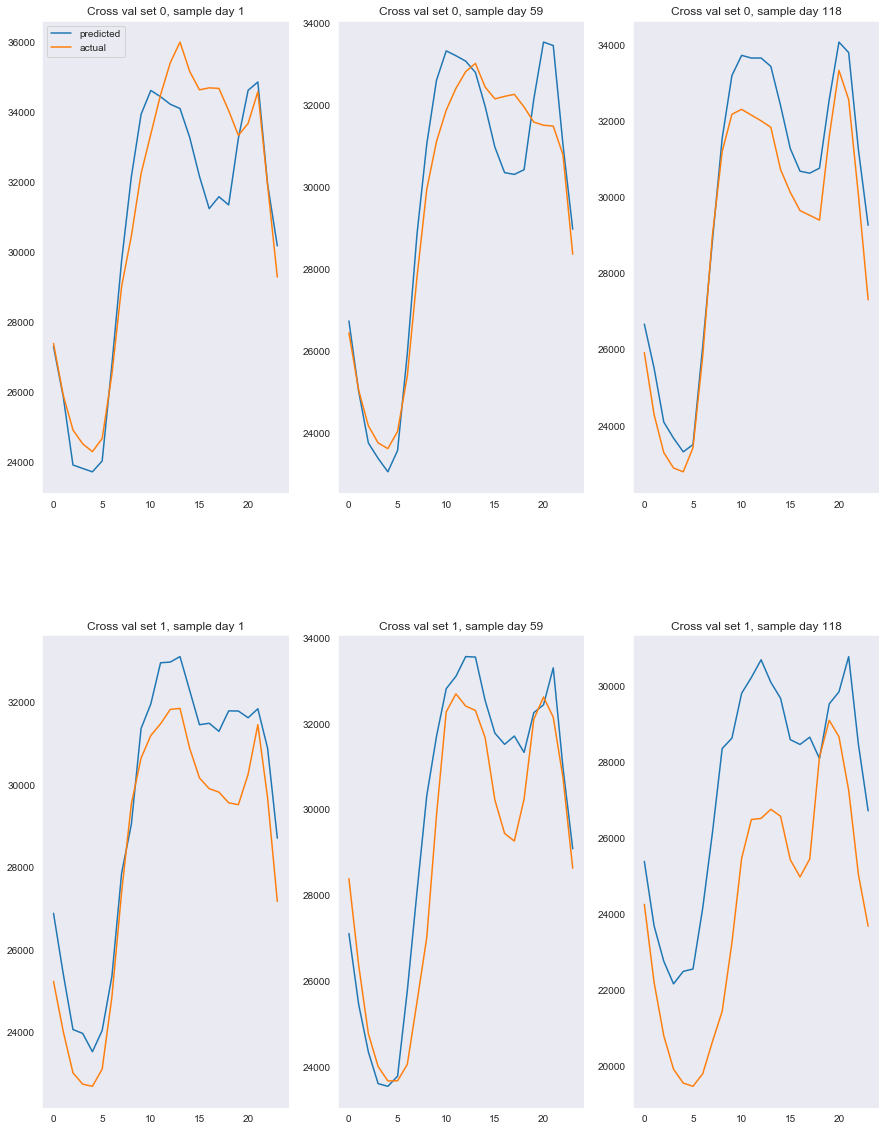

In [14]:
run_multi_var_lstm_pipe(n_lags=7, 
                        n_crossvals=2, 
                        epochs=50, 
                        lr = 1e-3, 
                        show_verbose=True, 
                        period_start = '2017-01-01', 
                        period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of crossvalidations: 2
Number of total feature vectors: 100
(335, 100, 24)
(335, 24)
Epoch 1/50
113/113 [==============================] - 15s 135ms/step - loss: 0.4195
Epoch 2/50
113/113 [==============================] - 1s 12ms/step - loss: 0.4116
Epoch 3/50
113/113 [==============================] - 1s 12ms/step - loss: 0.4003
Epoch 4/50
113/113 [==============================] - 1s 12ms/step - loss: 0.3822
Epoch 5/50
113/113 [==============================] - 1s 13ms/step - loss: 0.3479
Epoch 6/50
113/113 [==============================] - 1s 13ms/step - loss: 0.3463
Epoch 7/50
113/113 [==============================] - 1s 12ms/step - loss: 0.3099
Epoch 8/50
113/113 [==============================] - 1s 12ms/step - loss: 0.3140
Epoch 9/50
113/113 [==============================] - 1s 12ms/step - loss: 0.3111
Epoch 10/50
113/113 [==============================] - 1s 12ms/step - loss: 0.3051
Epoch 11/50
113/113 [=============================

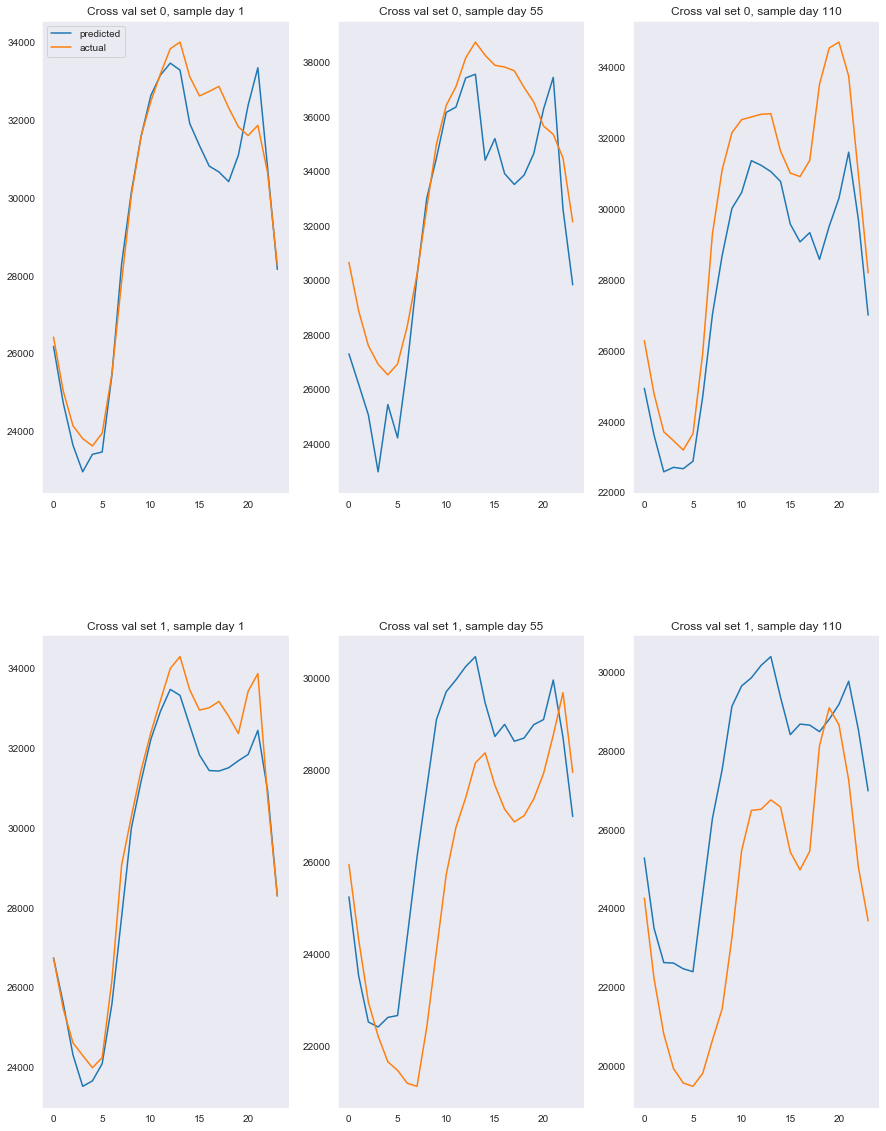

In [51]:
run_multi_var_lstm_pipe(n_lags=7, 
                        n_crossvals=2, 
                        epochs=50, 
                        lr = 1e-3, 
                        extra_lag=True, 
                        long_lag_step=7, 
                        max_lookback=30, 
                        show_verbose=True, 
                        period_start = '2017-01-01', 
                        period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of crossvalidations: 2
Number of total feature vectors: 180
(275, 180, 24)
(275, 24)
Epoch 1/50
93/93 [==============================] - 16s 170ms/step - loss: 0.4348
Epoch 2/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4278
Epoch 3/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4206
Epoch 4/50
93/93 [==============================] - 2s 20ms/step - loss: 0.4110
Epoch 5/50
93/93 [==============================] - 2s 20ms/step - loss: 0.3977
Epoch 6/50
93/93 [==============================] - 2s 21ms/step - loss: 0.3784
Epoch 7/50
93/93 [==============================] - 2s 21ms/step - loss: 0.3557
Epoch 8/50
93/93 [==============================] - 2s 20ms/step - loss: 73.0876
Epoch 9/50
93/93 [==============================] - 2s 20ms/step - loss: 0.3200
Epoch 10/50
93/93 [==============================] - 2s 20ms/step - loss: 0.3251
Epoch 11/50
93/93 [==============================] - 2s 20ms/step - l

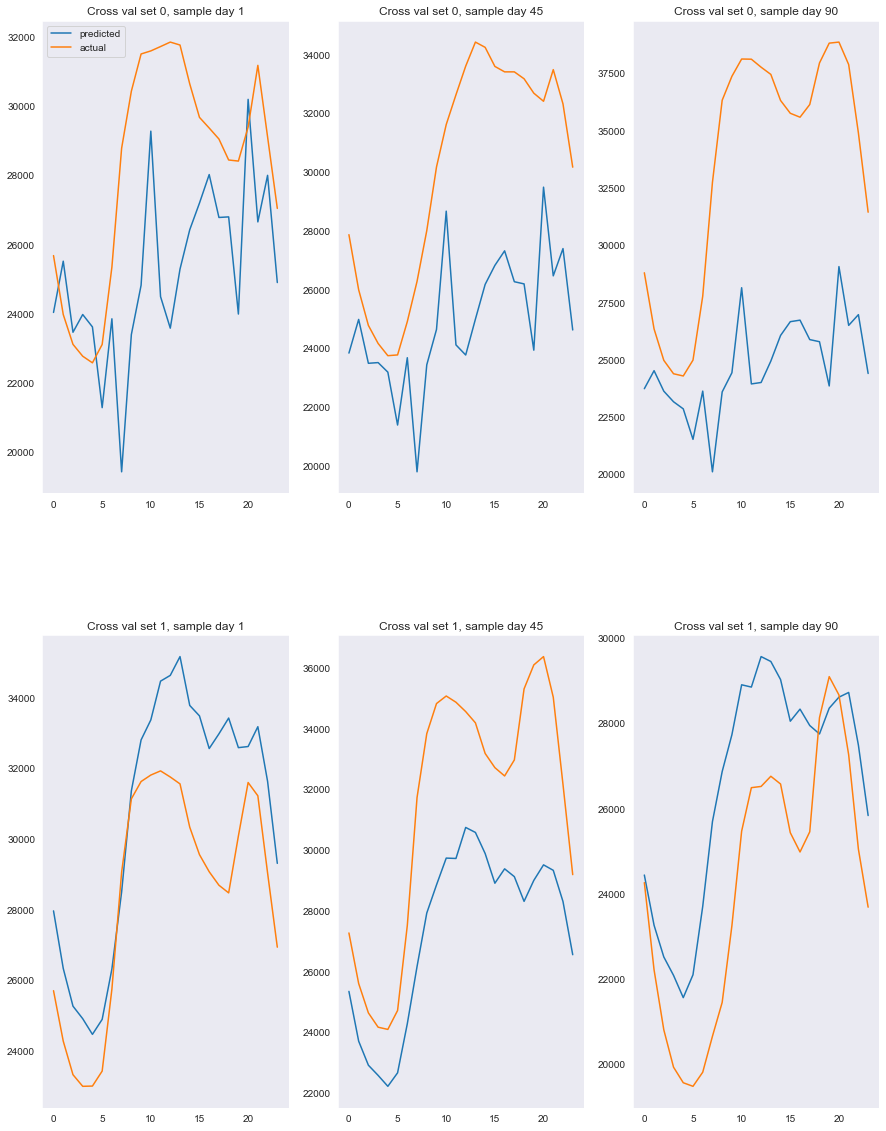

In [52]:
run_multi_var_lstm_pipe(n_lags=7, 
                        n_crossvals=2, 
                        epochs=50, 
                        lr = 1e-3, 
                        extra_lag=True, 
                        long_lag_step=7, 
                        max_lookback=90, 
                        show_verbose=True, 
                        period_start = '2017-01-01', 
                        period_end = '2017-12-31')

# Mulitvariate Preprocessing helper functions

In [39]:
def get_lstm_multivariable_data_3d(start='2015-01-01', stop='2015-01-05', n_lags=2, extra_lag=False, long_lag_step=7, max_lookback=30):

    #load in the prepared dataset
    all_data = pd.read_csv('./data/lstm/nn_dataset_2015_2018.csv', parse_dates=True, index_col=0)

    #select data time slice
    data = all_data[start: stop].copy()
    
    #reshape the energy load columns to prepare for minmax scaling
    energy = data['actual_load'].values.reshape(-1,1)
    
    #minmax scale the energy column
    scaler = MinMaxScaler().fit(energy)
    data_normd = scaler.transform(energy)
    
    #reset the energy column to the actual loads
    data['actual_load'] = data_normd.copy()
    
    #create single columns with time features
    data.loc[:,'year'] = data.index.year
    data.loc[:,'month'] = data.index.month
    data.loc[:,'day'] = data.index.day
    data.loc[:,'hours'] = data.index.hour
    
    hours_tup = [] 

    #for each unique hour isolate the features and dates
    for h in data.hours.unique():
        
        #boolean mask for each hour of the day
        hour = data[data.hours==h].copy()
        #drop the unneeded columns
        hour.drop(['year', 'month', 'day', 'hours'], axis=1, inplace=True)
        #reshape 2D into a 3D matrix for stacking
        hour = np.reshape(hour.values, (hour.shape[0], hour.shape[1], 1))
        #append each 3d slice into list
        hours_tup.append(hour)
    
    
    tup = tuple(hours_tup)
    
    #stack all the 3D arraysinto 1 single 3D array
    hours_stacked = np.dstack(tup)
    
    #make samples from hours stacked. result is 4D and 2D
    X_4d, y = split_sequences(hours_stacked, 
                           n_lags, 
                           extra_lag=extra_lag, 
                           long_lag_step=long_lag_step, 
                           max_step=max_lookback, 
                           idx=0, 
                           multivar=True)
    #X_4d, y = split_sequences(hours_stacked, n_lags, idx=0, multivar=True)
    
    
    X = []

    #flatten the 2nd and 3rd dimensions together to have a final array of samples, lags & features, hours
    for j in range(len(X_4d)):
        #reshape the inner dimensions
        n = X_4d[j].reshape(-1, hours_stacked.shape[-1])
        X.append(n)
    
    X = np.array(X)
    
    
    return X, y, scaler

In [40]:
X_, y_, scaler_energy = get_lstm_multivariable_data_3d(start='2015-01-01', stop='2015-01-05', n_lags=2)
X_.shape, y_.shape

((3, 20, 24), (3, 10))

In [14]:
def get_lstm_multivariable_data_4d(start='2015-01-01', stop='2015-01-05', n_lags=2):

    #load in the prepared dataset
    all_data = pd.read_csv('./data/lstm/nn_dataset_2015_2018.csv', parse_dates=True, index_col=0)

    #select data time slice
    data = all_data[start: stop].copy()
    
    #list to store the windows of 2D feature data
    windowed_data = []

    #for each 2d feautre window 
    for col in data.columns:
        #transform each column to row of dates, with columns as the hourly slices
        window = transform_to_windows(data, load_type=col)

        #if the column is actual load, we need to scale it, otherwise all columns are already scaled
        if col == 'actual_load':
            window, scaler = normalize_df(window)

        #reshape each 2D feature window into 3D so it can be stacked
        window = np.reshape(window.values, (window.shape[0], window.shape[1], 1))
        
        #append to list
        windowed_data.append(window)
        
    #convert list of 2D feature windows to a numpy array
    windowed_data = np.array(windowed_data)

    tup = []

    #make a list of each 2D dataslice to stack
    for i in range(len(windowed_data)):
        tup.append(windowed_data[i])

    #tun into a tuple
    tup = tuple(tup)

    #stack up the 2d feature windows to a 3D array
    windows_stacked = np.dstack(tup)

    #split the 3D data into 4D slices of X and y. multivar True to select only the index value of the y array.
    #indx is the location of the y target values.
    X, y = split_sequences(windows_stacked, n_lags, idx=0, multivar=True)
    
    return X, y, scaler

In [243]:
X, y, scaler_y = get_lstm_multivariable_data(start='2015-01-01', stop='2015-01-05')
X.shape, y.shape

((3, 2, 24, 10), (3, 24, 1))

## Investigating function of Blocking Time Series Split 

Modification of the SKLearn TimeSeries Split Class. This variant maintains a fixed train size and does not retrain on data previously tested. Was not implemented in the final models. 

In [136]:
bscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in bscv.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] TEST: [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69] TEST: [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98 

In [72]:
X_train.shape, X_test.shape

((30, 7, 24), (17, 7, 24))

In [73]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

## Original Test LSTM

This section is a workspace where I used an simple lstm to:
- set the learning rate
- understand the basic input data structure

In [152]:
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

If using batch size the batch must split an entire training example. For simplicity we use batch gradient descent.

##### Learning rate search method
Search over range 1e-4 to 8.9e0. Find the range where learning rate reduced the most and reduce search area to find optimal.

In [187]:
print(1e-4 *(10**(np.arange(100)/30)))

[1.00000000e-04 1.07977516e-04 1.16591440e-04 1.25892541e-04
 1.35935639e-04 1.46779927e-04 1.58489319e-04 1.71132830e-04
 1.84784980e-04 1.99526231e-04 2.15443469e-04 2.32630507e-04
 2.51188643e-04 2.71227258e-04 2.92864456e-04 3.16227766e-04
 3.41454887e-04 3.68694506e-04 3.98107171e-04 4.29866235e-04
 4.64158883e-04 5.01187234e-04 5.41169527e-04 5.84341413e-04
 6.30957344e-04 6.81292069e-04 7.35642254e-04 7.94328235e-04
 8.57695899e-04 9.26118728e-04 1.00000000e-03 1.07977516e-03
 1.16591440e-03 1.25892541e-03 1.35935639e-03 1.46779927e-03
 1.58489319e-03 1.71132830e-03 1.84784980e-03 1.99526231e-03
 2.15443469e-03 2.32630507e-03 2.51188643e-03 2.71227258e-03
 2.92864456e-03 3.16227766e-03 3.41454887e-03 3.68694506e-03
 3.98107171e-03 4.29866235e-03 4.64158883e-03 5.01187234e-03
 5.41169527e-03 5.84341413e-03 6.30957344e-03 6.81292069e-03
 7.35642254e-03 7.94328235e-03 8.57695899e-03 9.26118728e-03
 1.00000000e-02 1.07977516e-02 1.16591440e-02 1.25892541e-02
 1.35935639e-02 1.467799

In [177]:
#set a learning rate scheduler to optimize the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch : 1e-4 * 10**(epoch/20))

#initalize the model
vanilla_model = vanilla_lstm(input_shape)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 7s 227ms/step - loss: 0.4915
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4911
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4906
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4899
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4892
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4884
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4875
Epoch 8/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4865
Epoch 9/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4854
Epoch 10/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4842
Epoch 11/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4828
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.4813
Epoch 13/100
29/29 [===============

In [53]:
def plot_loss(history, scale=20, semilog=True):
    fig = plt.figure(figsize=(8,7))
    
    #values for the x axis - same as the changes in the learning rate
    lrs = 1e-4 *(10**(np.arange(100)/scale))
    
    if semilog:
        #history values for the loss
        plt.semilogx(lrs, history.history['loss'])
        #set the y axis limits
        plt.ylim((0.01, 1))
        #label names
        plt.xlabel('Leaning rate semilog scale')
        plt.title('Loss ')
        
    else:
        plt.plot(history.history['loss'])
        plt.xlabel('Epochs')
        plt.ylim((0.01, 0.5))
    

    

    plt.ylabel('Loss')

    
    plt.show()

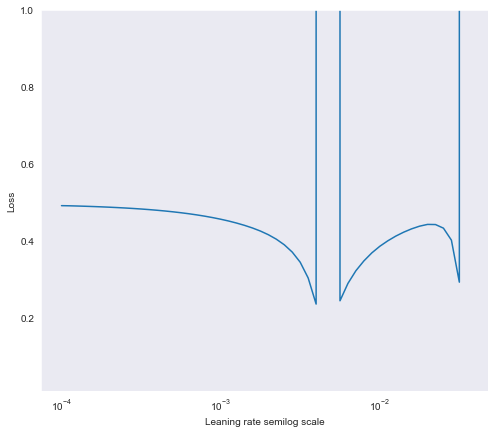

In [183]:
plot_loss(history_vm, 20)

In [188]:
#set a learning rate scheduler to optimize the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch : 1e-4 * 10**(epoch/30))

#initalize the model
vanilla_model = vanilla_lstm(input_shape)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 7s 231ms/step - loss: 0.4704
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4699
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4694
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4688
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4682
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4675
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4668
Epoch 8/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4660
Epoch 9/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4652
Epoch 10/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4643
Epoch 11/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4633
Epoch 12/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4623
Epoch 13/100
29/29 [===============

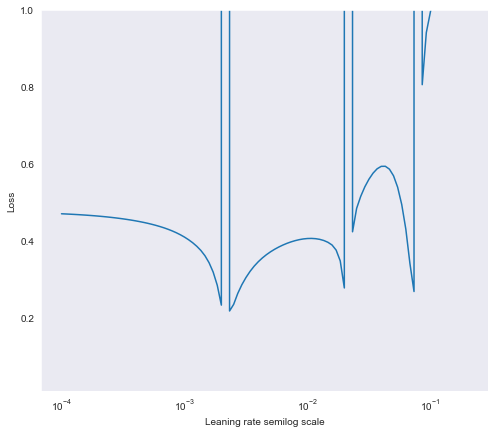

In [190]:
plot_loss_callbacks(history_vm, 30)

##### Long run

After some experimentation we will run the model for 500 epochs on a learning rate of 1e-3.

In [203]:
#initalize the model
vanilla_model = vanilla_lstm(input_shape, learning_rate=1e-3)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=500)

Epoch 1/500
29/29 [==============================] - 5s 176ms/step - loss: 0.4708
Epoch 2/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4662
Epoch 3/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4616
Epoch 4/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4571
Epoch 5/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4525
Epoch 6/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4479
Epoch 7/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4434
Epoch 8/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4386
Epoch 9/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4339
Epoch 10/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4290
Epoch 11/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4240
Epoch 12/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4188
Epoch 13/500
29/29 [===============

Epoch 103/500
29/29 [==============================] - 0s 8ms/step - loss: 0.2233
Epoch 104/500
29/29 [==============================] - 0s 7ms/step - loss: 0.2222
Epoch 105/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2212
Epoch 106/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2202
Epoch 107/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2192
Epoch 108/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2181
Epoch 109/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2171
Epoch 110/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2161
Epoch 111/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2151
Epoch 112/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2141
Epoch 113/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2131
Epoch 114/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2121
Epoch 115/500
29

Epoch 203/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0792
Epoch 204/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0785
Epoch 205/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0777
Epoch 206/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0770
Epoch 207/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0763
Epoch 208/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0756
Epoch 209/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0750
Epoch 210/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0744
Epoch 211/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0738
Epoch 212/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0733
Epoch 213/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0727
Epoch 214/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0722
Epoch 215/500
29

Epoch 303/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0726
Epoch 304/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0698
Epoch 305/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0615
Epoch 306/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 307/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0836
Epoch 308/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0499
Epoch 309/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0646
Epoch 310/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0732
Epoch 311/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0777
Epoch 312/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0796
Epoch 313/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0797
Epoch 314/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0783
Epoch 315/500
29

Epoch 403/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 404/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 405/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 406/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 407/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 408/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 409/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 410/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0420
Epoch 411/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0419
Epoch 412/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 413/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 414/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 415/500
29

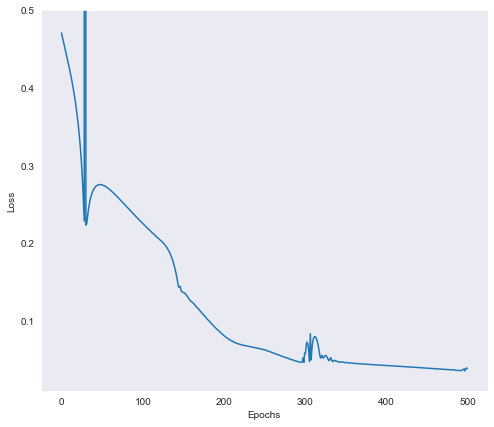

In [204]:
plot_loss(history_vm, semilog=False)

### Make predictions on the test data

In [206]:
Y_hat_test = vanilla_model.predict(X_test)

In [209]:
Y_hat_test.shape, Y_test.shape

((6, 24), (6, 24))

In [30]:
def plot_predictions(Y_hat_test, Y_test):
    fig = plt.figure(figsize=(8,7))

    
    #flatten the hourly slices into single univariate series
    #plot predictions
    plt.plot(Y_hat_test.flatten(), label='Predicted Load')
    #plot actual
    plt.plot(Y_test.flatten(), label='Actual Load')
    
    plt.xlabel('Hours')
    plt.ylabel('Normalized MWh')
    

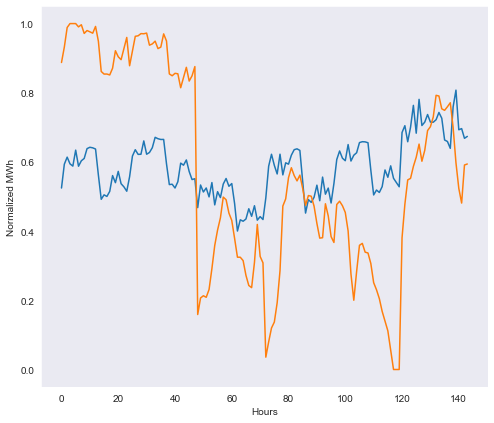

In [234]:
plot_predictions(Y_hat_test, Y_test)

##### Calculate RMSE: Small batch test run



In [255]:
def rescale_results(data, scaler):
    #function rescales the data so when calcualting RMSE we have comparable metrics
    
    return scaler.inverse_transform(data)
    

In [247]:
def convert_df(result, test):
    
    #convert the numpy results back to a dataframe so we can use the calculate_errors helper function
    
    y_cols = ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']
    
    index = test.index
    
    return pd.DataFrame(result, index=index, columns=y_cols)

In [256]:
Y_hat_test_df = convert_df(rescale_results(Y_hat_test, scaler), test)
Y_test_df = convert_df(rescale_results(Y_test, scaler), test)

In [257]:
error_model, errors_hourly = calculate_errors(Y_hat_test_df, Y_test_df, 'LSTM Small Batch')
print('Small batch LSTM 1 month training data, predicting 6 days total RMSE: {}'.format(error_model))

Small batch LSTM 1 month training data, predicting 6 days total RMSE: 3965.835409684048


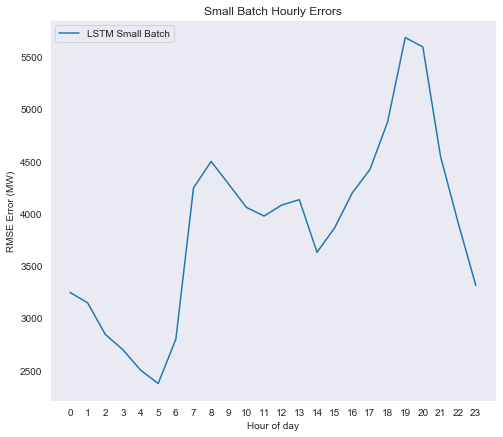

In [260]:
plot_error(errors_hourly, result_set=['LSTM Small Batch'], title='Small Batch Hourly Errors')

### Univariate model with many lags

Based on the results of the SARIMA model we see that early lags were underrepresented in the trend.

Try an LSTM with many features concentrated around last 2 weeks plus one week a month ago.

In [47]:
shift_list = [x for x in range(0,7)] #+ [x for x in range(7,30) if x%2 == 1]

print('Current list of shifts: {}' .format(shift_list))

#load the data set and the inverse scaler
train, test, scaler  = nn_univariate_dataset(start='2017-07-01', stop='2018-03-13', split='2017-12-31', shift_list=shift_list, normalize=True)

print('Number of days in the train set {}'.format(train.shape[0]))
print('Number of days in the test set {}'.format(test.shape[0]))

#prepare the data and get input dims
X, Y, input_shape = prep_data(train, test)

#set the current test X and Y train and test
X_train, X_test = X
Y_train, Y_test = Y

#set the forecast horizon
n_steps_out = 24

Current list of shifts: [0, 1, 2, 3, 4, 5, 6]
Number of days in the train set 178
Number of days in the test set 72


In [48]:
vanilla_model = vanilla_lstm(input_shape, n_steps_out, cells=25, learning_rate=1e-3)

history_vm_extra_lag = vanilla_model.fit(X_train, Y_train, epochs=25, batch_size = 64, validation_split=0.3, shuffle=False)

Train on 124 samples, validate on 54 samples
Epoch 1/25
124/124 [==============================] - 3s 20ms/step - loss: 0.2655 - val_loss: 0.3049
Epoch 2/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2593 - val_loss: 0.2969
Epoch 3/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2523 - val_loss: 0.2885
Epoch 4/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2449 - val_loss: 0.2800
Epoch 5/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2373 - val_loss: 0.2708
Epoch 6/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2291 - val_loss: 0.2608
Epoch 7/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2203 - val_loss: 0.2499
Epoch 8/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2105 - val_loss: 0.2376
Epoch 9/25
124/124 [==============================] - 1s 8ms/step - loss: 0.1995 - val_loss: 0.2234
Epoch 10/25
124/124 [==============================] -

KeyboardInterrupt: 

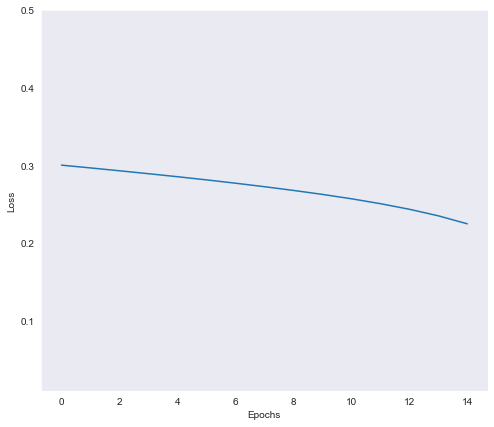

In [55]:
plot_loss(history_vm_extra_lag, semilog=False)

###### Forecast from many lags

In [38]:
Y_hat_many_lag = vanilla_model.predict(X_test)

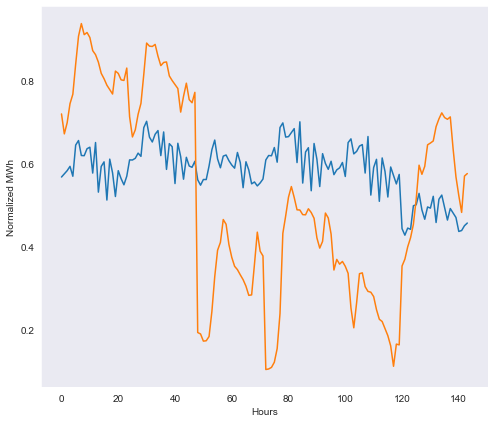

In [39]:
plot_predictions(Y_hat_many_lag, Y_test)